## Camera sensors


In [1]:
%load_ext autoreload
%autoreload 1
%aimport evc_black_level, evc_histogram_clipping, evc_white_balance, evc_demosaic, evc_gamma_correction, evc_compute_binary, GUI.gui_white_balance, GUI.gui_gamma_correction, GUI.gui_gamma_histogram_clipping, GUI.gui_shared
#%matplotlib inline

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from GUI.ipython_helper import imEmbed

import evc_black_level, evc_histogram_clipping, evc_white_balance, evc_demosaic, evc_gamma_correction, evc_compute_binary
from GUI import gui_white_balance, gui_gamma_correction, gui_gamma_histogram_clipping

### Select image file
First, define the path of the image you want to deal with below. They are located in the images directory. 

In [2]:
file = '0\\IMG_5.tiff'

### Black Level
Since all of our images are saved as 16-bit TIFFs and we are provided with some metadata, we first will use this and extract the blacklevel and "as-shot-neutral" to transform the image. In evc_black_level, complete the function evc_read_file_info which should return those two variables by iterating over the metadata dictionary provided by PIL.

In [3]:
pattern = 'RGGB'
img_pil = Image.open(file)

blackLevel, asShotNeutral = evc_black_level.evc_read_file_info(file)
print(blackLevel, asShotNeutral)

1439 (0.454302, 1.0, 0.657419)


Next, implement evc_transform_colors which maps the image from [blackLevel, 65535] to [0, 1].

In [4]:
img = np.asarray(img_pil)
img_transformed_color = evc_black_level.evc_transform_colors(img, blackLevel)
print(np.max(img_transformed_color), np.min(img_transformed_color))
print(img_transformed_color.shape)

1.0 0.0
(1738, 1158)


### Demosaic
Once our image is in the correct domain, we can apply the preprocessing: The images are captures by cameras using sensors with color filters and specific patterns commonly known as Bayer Patterns. (RGGB, BGGR, GRBG, GBRG).

In [5]:
r, g, b = evc_demosaic.evc_demosaic_pattern(img_transformed_color, pattern)

Since we now obtained the red, blue and green channel, we can make use of the 'asShotNeutral' from above: In evc_demosaic.evc_transform_neutral, divide each channel by its respective value of the variable asShotNeutral.

In [6]:
R_trans, G_trans, B_trans = evc_demosaic.evc_transform_neutral(r,g,b, asShotNeutral)

We are almost done with the preprocessing: Due to the bayer pattern, we only have quarter/half of the information (=pixels) for each channel. The remaining pixels are still zero.

In [7]:
R_inter, G_inter, B_inter = evc_demosaic.evc_interpolate(R_trans, G_trans, B_trans)


In evc_concat, concatenate the red, green, and blue channel so we can plot the image below.

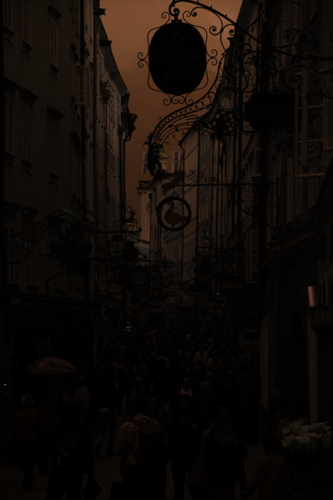

In [8]:
img_demosaic = evc_demosaic.evc_concat(R_inter, G_inter, B_inter)
imEmbed(img_demosaic / np.max(img_demosaic))

### White balance

We're done with the preprocessing, now we focus on enhancing the image. First, we implement white balancing. The GUI should guide you through the white balancing process and a nice image should be plotted below.

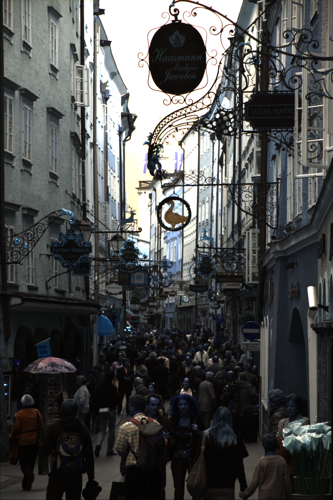

In [9]:
img_wb = gui_white_balance.gui_white_balance(img_demosaic)
imEmbed(img_wb)

### Gamma correction
Since the human eye has different perception for dark and bright areas (== non-linear), we can target this by a non-linear transformation known as gamma-correction (f(x) = x^i, where i is a parameter). Apply the gamma correction via the provided gui to the white balanced image.

Secondly, we deal with a gamma correction which focuses on brightness.

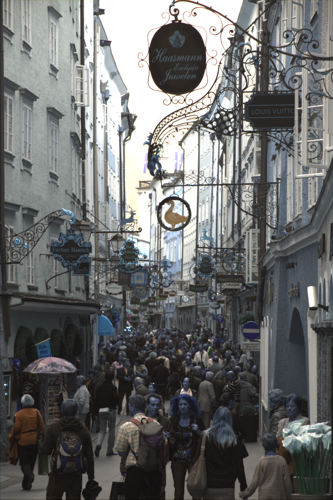

In [10]:
img_gamma_corrected = gui_gamma_correction.gui_gamma_correction(img_wb)
imEmbed(img_gamma_corrected)

### Contrast enhancement
Gamma corrected images usually suffer from low contrast - we can tackle this issue by implementing contrast enhancement.

In [11]:
low, high = gui_gamma_histogram_clipping.gui_gamma_histogram_clipping(img_gamma_corrected)
print (f'low: {low}, high: {high}')

c:\Users\ivah\Documents\basics-of-cumputer-graphics\cameras\evc_histogram_clipping.py:31: RuntimeWarning: divide by zero encountered in divide
  output_image = output_image / new_high
c:\Users\ivah\Documents\basics-of-cumputer-graphics\cameras\evc_histogram_clipping.py:31: RuntimeWarning: invalid value encountered in divide
  output_image = output_image / new_high
c:\Users\ivah\Documents\basics-of-cumputer-graphics\cameras\GUI\gui_gamma_histogram_clipping.py:214: RuntimeWarning: invalid value encountered in cast
  self._img_label_main.set_image(np.clip(self.img_corrected*255,0,255).astype(np.uint8))


ValueError: autodetected range of [nan, nan] is not finite

low: 0.11, high: 0.9


In [12]:
newLow, newHigh = evc_histogram_clipping.evc_prepare_histogram_range(img_gamma_corrected, low, high)

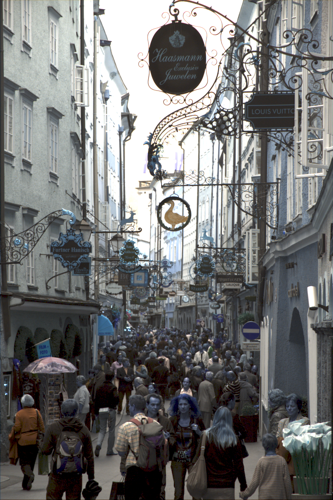

In [13]:
img_norm = evc_histogram_clipping.evc_transform_histogram(img_gamma_corrected, newLow, newHigh)
imEmbed(img_norm)

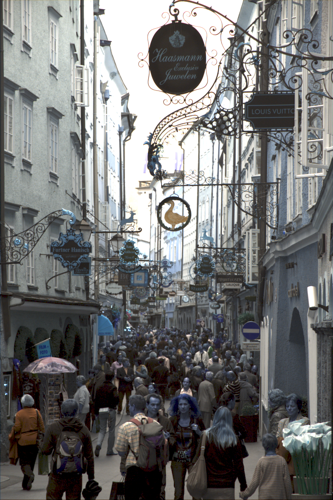

In [14]:
img_clipped = evc_histogram_clipping.evc_clip_histogram(img_norm)
imEmbed(img_clipped)